In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background'])

dx: 0.7807807807807807 cm
nx 1000


Text(0, 0.5, 'z (m)')

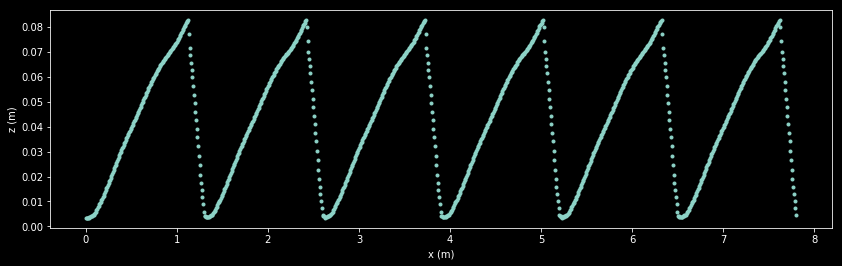

In [18]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1000)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [24]:
model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(xc, zc, dx)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.247

model.flow_boundary_conditions(q32cm, sOut32)

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.00333
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.TVD2ndWenoModel()
# morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 3.*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1.0


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
df = model.get_wave_dataframe()

df.to_csv('Equilbrium_Ycr')

fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

surf = zc + h

plt.plot(xc, surf)

 Starting simulation....
Number of time steps: 0.6 mins
Grid dx = 0.007807807807807808
Grid nx = 1000
Initializing hydrodynamic model...
2019-05-15 17:15:49,702 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 17:16:30,821 INFO CLAW: Solution 1 computed for time t=294.195699
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 9.006740197330712e-06
2019-05-15 17:16:30,883 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 17:16:32,302 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-15 17:16:32,541 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 17:16:34,389 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-15 17:16:34,439 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 17:16:35,639 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-15 17:16:35,765 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 17:16:37,461 INFO CLAW: So

NameError: name 'model' is not defined

In [25]:
df = model.get_wave_dataframe()

In [26]:
df

,height,length,speed
60,0.079133,3.91015,0.210811
120,0.078834,3.91015,0.218619
